# Import Library

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression  
from sklearn.pipeline import make_pipeline  
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import train_test_split  

from keras.models import Sequential  
from keras.layers import Embedding, SimpleRNN, LSTM, Dense  
from keras.callbacks import EarlyStopping  

from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences  

from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords  
from nltk.stem import PorterStemmer  
import nltk  

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory  
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory  

from google_play_scraper import app, reviews, Sort, reviews_all  

from wordcloud import WordCloud  
from textblob import TextBlob  

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import datetime as dt  
import re  
import string  

# Pengaturan opsional
pd.options.mode.chained_assignment = None  
np.random.seed(0)  

# Unduh resource NLTK
nltk.download('punkt')  
nltk.download('stopwords')  
# 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akmal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
# Membuat DataFrame dari hasil scrapreview
# app_reviews_df = pd.DataFrame(scrapreview)
app_reviews_df = pd.read_csv('ulasan_aplikasi.csv')

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = app_reviews_df.shape

app_reviews_df.info()  # Menampilkan informasi tentang DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15000 non-null  object
 1   userName              15000 non-null  object
 2   userImage             15000 non-null  object
 3   content               15000 non-null  object
 4   score                 15000 non-null  int64 
 5   thumbsUpCount         15000 non-null  int64 
 6   reviewCreatedVersion  13565 non-null  object
 7   at                    15000 non-null  object
 8   replyContent          2 non-null      object
 9   repliedAt             2 non-null      object
 10  appVersion            13565 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [35]:
clean_df = app_reviews_df.drop(columns=['replyContent', 'repliedAt'])  # Menghapus kolom replycontent dan repliedat karena tidak sebagian besar data kosong
clean_df = clean_df.dropna()  # Menghapus baris yang memiliki data kosong
clean_df = clean_df.drop_duplicates() # Menghapus baris duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = clean_df.shape # Menghitung jumlah baris dan kolom setelah menghapus duplikat
clean_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 13565 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13565 non-null  object
 1   userName              13565 non-null  object
 2   userImage             13565 non-null  object
 3   content               13565 non-null  object
 4   score                 13565 non-null  int64 
 5   thumbsUpCount         13565 non-null  int64 
 6   reviewCreatedVersion  13565 non-null  object
 7   at                    13565 non-null  object
 8   appVersion            13565 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.0+ MB


# Pre Processing Data

In [36]:
# Daftar kata tidak efektif yang akan dihapus  
useless_words = [  
    'im', 'its', 'youre', 'wont', 'cant', 'ill', 'youve', 'theyre', 'theres',  
    'gonna', 'gotta', 'kinda', 'want', 'going', 'dont', 'isnt', 'wasnt', 'hasnt',  
    'havent', 'shouldnt', 'couldnt', 'wouldnt', 'might', 'maybe', 'probably',  
    'anyway', 'actually', 'really', 'like', 'just', 'so', 'very', 'this', 'that',  
    'there', 'here', 'what', 'why', 'how', 'who', 'when', 'which', 'but', 'and',  
    'or', 'if', 'than', 'with', 'about', 'for', 'as', 'of', 'at', 'to', 'in',  
    'on', 'an', 'the', 'a', 'by', 'such', 'oh', 'uh', 'um', 'like', 'want',   
    'need', 'make', 'go', 'see', 'know', 'say', 'get', 'give', 'take', 'have',   
    'do', 'be', 'would', 'should', 'could', 'is', 'are', 'was', 'were', 'am',  
    'like', 'my', 'your', 'his', 'her', 'its', 'our', 'their', 'myself',   
    'yourself', 'himself', 'herself', 'itself', 'themselves', 'each', 'every',  
    'anyone', 'someone', 'nobody', 'everybody', 'thing', 'stuff', 'bit', 'still', 'even'  
]

def cleaningText(text):  
    text = re.sub(r'@[A-Za-z0-9]+', '', text)   # Menghapus mention  
    text = re.sub(r'#[A-Za-z0-9]+', '', text)   # Menghapus hashtag  
    text = re.sub(r'RT[\s]', '', text)          # Menghapus "RT"  
    text = re.sub(r'http\S+', '', text)         # Menghapus tautan  
    text = re.sub(r'[0-9]+', '', text)          # Menghapus angka  
    text = re.sub(r'[^\w\s]', '', text)         # Menghapus tanda baca  

    text = text.replace('\n', ' ')              # Mengganti newline dengan spasi  
    text = text.strip()                         # Menghapus white space di awal dan akhir  
    return text  

def casefoldingText(text):  # Mengubah semua karakter menjadi huruf kecil  
    return text.lower()  

def tokenizingText(text):  # Tokenisasi teks menjadi daftar token  
    return word_tokenize(text)  

def filteringText(text):  # Menghapus stopwords dan kata tidak efektif dari teks  
    listStopwords = set(stopwords.words('english'))  # Menggunakan stopwords dalam bahasa Inggris  
    filtered = [word for word in text if word not in listStopwords and word not in useless_words]  
    return filtered  

def stemmingText(text):  # Stemming  
    stemmer = PorterStemmer()  
    
    words = text.split()  # Memecah teks menjadi kata  
    stemmed_words = [stemmer.stem(word) for word in words]  # Menerapkan stemming  
    return ' '.join(stemmed_words)  # Menggabungkan kata-kata yang telah distem  

def toSentence(list_words):  # Mengubah daftar kata kembali menjadi kalimat  
    return ' '.join(list_words)  

In [37]:
slangwords_en = {  
    "brb": "be right back",  
    "bty": "be there soon",  
    "lol": "laughing out loud",  
    "omg": "oh my god",  
    "idk": "I don't know",  
    "gtg": "got to go",  
    "thx": "thanks",  
    "bff": "best friends forever",  
    "fomo": "fear of missing out",  
    "tbh": "to be honest",  
    "smh": "shaking my head",  
    "afk": "away from keyboard",  
    "lmbo": "laughing my butt off",  
    "asap": "as soon as possible",  
    "imo": "in my opinion",  
    "wbu": "what about you",  
    "diy": "do it yourself",  
    "bae": "before anyone else",  
    "cya": "see you",  
    "np": "no problem",  
    "yw": "you’re welcome",  
    "tba": "to be announced",  
    "tbc": "to be continued",  
    "jk": "just kidding",  
    "btw": "by the way",  
    "lmao": "laughing my ass off",  
    "smh": "shaking my head",  
    "tbh": "to be honest",  
    "srsly": "seriously",  
    "bde": "big dick energy",  
    "cba": "can't be arsed",  
    "fam": "friends or family",  
    "lit": "exciting or excellent",  
    "salty": "bitter or upset",  
    "ghosting": "sudden withdrawal from communication",
    "shook": "surprised or shocked",  
    "vibes": "mood or atmosphere",  
    "savage": "bold and fierce",  
    "stan": "overzealous fan",  
    "slay": "do really well",  
    "woke": "aware of social injustices",  
    "lit af": "extremely exciting",  
    "sus": "suspicious",  
    "extra": "over the top",  
    "flex": "show off",  
    "spill the tea": "gossip",  
    "shade": "subtle insult",  
    "bussin": "really good (usually food)",  
    "simp": "someone who shows excessive sympathy",  
    "guid": "good",  
    "clout": "influence or power",  
    "bang": "very good",  
    "snatched": "looking good or attractive",  
    "throw shade": "make a subtle negative comment",  
    "drip": "style or sense of fashion",  
    "mood": "feeling or vibe",  
    "cancelled": "rejected or disapproved",  
    "fire": "awesome or great",  
    "cheugy": "out of date or trying too hard",  
    "cringe": "embarrassing or awkward",  
    "lowkey": "subtly or secretly",  
    "highkey": "openly or obviously",  
    "on fleek": "perfectly done",  
    "slippery slope": "a situation that worsens gradually",  
    "turnt": "excited or intoxicated",  
    "canceled": "no longer in favor",  
    "go off": "to speak one's mind freely",  
    "facts": "truth or reality",  
    "litty": "very fun or exciting",  
    "pov": "point of view",  
    "sips tea": "observing a situation quietly",  
    "troll": "to provoke online",  
    "yolo": "you only live once",  
    "broke": "having no money",  
    "cray": "crazy",  
    "glow up": "to improve one's appearance or life",  
    "finesse": "to handle a difficult situation well",  
    "let's go": "I'm excited",  
    "fam": "family or close friends",  
    "pop off": "to suddenly become very successful",  
    "for real": "seriously",  
    "bet": "okay or I agree",  
    "real talk": "talking frankly",  
    "pushing buttons": "provoking a reaction",  
    "all in": "fully invested or committed", 
    "k": "okay",  
    "b": "be right back",  
    "nah": "no",  
    "yaas": "yes",  
    "hype": "excitement",  
    "pouting": "not happy",  
    "iys": "I guess",  
    "gos": "gossip",  
    "whatevs": "whatever",  
    "lpfm": "laughing pretty f***ing much",  
    "srs": "serious",  
    "solid": "great or reliable",  
    "deets": "details",  
    "zoned out": "lost focus",  
    "slide into DMs": "send a private message",  
    "banger": "a really good song",  
    "on point": "exactly right",  
    "kudos": "praise or compliments",  
    "jokes": "stories not meant to be taken seriously",  
    "tbh": "to be honest",  
    "fired": "dismissed from a job",  
    "binge-watch": "watching multiple episodes in one sitting",  
    "adulting": "behaving like an adult",  
    "gotcha": "I understand",  
    "would": "I would agree",  
    "wth": "what the hell",  
    "gg": "good game",  
    "sore loser": "someone who cannot take losing well",  
    "low-key": "subtle or not obvious",  
    "sick": "awesome",  
    "unsend": "retract a message",  
    "vibe check": "assess the mood",  
    "weird flex": "an odd way to show off",  
    "dude": "person (gender-neutral)",  
    "hundo": "hundred percent",  
    "extra af": "overly dramatic",  
    "slay queen": "a confident and fierce woman",  
    "partner in crime": "close friend",  
    "adulting": "acting like a responsible adult",  
    "salty": "bitter",  
    "budget": "cheap or not expensive",  
    "pumped": "excited",  
    "messy": "disorganized situation",  
    "lmao": "laughing my ass off",  
    "shook": "unexpectedly surprised",  
    "catch these hands": "to fight someone",  
    "clutch": "done perfectly in a critical situation",  
    "bait": "temptation for someone to take action",  
    "basic": "mainstream or unoriginal",  
    "stan": "to be an overzealous fan",  
    "buss": "very good",  
    "fact": "truth, often stated in arguments",  
}  

def fix_slangwords(text):  
    words = text.split()  
    fixed_words = []  

    for word in words:  
        if word.lower() in slangwords_en:  
            fixed_words.append(slangwords_en[word.lower()])  
        else:  
            fixed_words.append(word)  

    fixed_text = ' '.join(fixed_words)  
    return fixed_text  

In [38]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)


In [39]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,5f4936ea-f0f3-44d1-b6ea-239a16387aa4,A Google user,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"All's well considering the site we're using, however: please, please, PLEASE, just STOP reloading my page the very moment the app launches. Way too often does this double launch get in the way of content I actually enjoy. I'd start the app, see some cool art or something actually interesting for a split second upon launch, only for it to be yeeted to oblivion wherever in the feed it ends up. Then I'm left either to search endlessly for it, or just give up, and lately it's been the later.",4,429,10.86.0-release.0,2025-04-03 04:40:55,10.86.0-release.0,Alls well considering the site were using however please please PLEASE just STOP reloading my page the very moment the app launches Way too often does this double launch get in the way of content I actually enjoy Id start the app see some cool art or something actually interesting for a split second upon launch only for it to be yeeted to oblivion wherever in the feed it ends up Then Im left either to search endlessly for it or just give up and lately its been the later,alls well considering the site were using however please please please just stop reloading my page the very moment the app launches way too often does this double launch get in the way of content i actually enjoy id start the app see some cool art or something actually interesting for a split second upon launch only for it to be yeeted to oblivion wherever in the feed it ends up then im left either to search endlessly for it or just give up and lately its been the later,alls well considering the site were using however please please please just stop reloading my page the very moment the app launches way too often does this double launch get in the way of content i actually enjoy id start the app see some cool art or something actually interesting for a split second upon launch only for it to be yeeted to oblivion wherever in the feed it ends up then im left either to search endlessly for it or just give up and lately its been the later,"[alls, well, considering, the, site, were, using, however, please, please, please, just, stop, reloading, my, page, the, very, moment, the, app, launches, way, too, often, does, this, double, launch, get, in, the, way, of, content, i, actually, enjoy, id, start, the, app, see, some, cool, art, or, something, actually, interesting, for, a, split, second, upon, launch, only, for, it, to, be, yeeted, to, oblivion, wherever, in, the, feed, it, ends, up, then, im, left, either, to, search, endlessly, for, it, or, just, give, up, and, lately, its, been, the, later]","[alls, well, considering, site, using, however, please, please, please, stop, reloading, page, moment, app, launches, way, often, double, launch, way, content, enjoy, id, start, app, cool, art, something, interesting, split, second, upon, launch, yeeted, oblivion, wherever, feed, ends, left, either, search, endlessly, lately, later]",alls well considering site using however please please please stop reloading page moment app launches way often double launch way content enjoy id start app cool art something interesting split second upon launch yeeted oblivion wherever feed ends left either search endlessly lately later
1,15b829dc-ad70-402b-8766-483296bc57e0,A Google user,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"This app is just awful. It crashes every 5 minutes and I have to completely uninstall it and reinstall it just to get it to work for a couple hours more before it starts again. It refreshes the timeline randomly causing me to miss posts I really wanted to see, and it's clear all the focus

# Labeling

In [40]:
# Fungsi untuk menilai sentimen menggunakan TextBlob
def analyze_with_textblob(text):
    blob = TextBlob(text)
    polarity_score = blob.sentiment.polarity  # -1 to 1
    if polarity_score > 0.05:
        polarity = "positive"
    elif polarity_score < 0.05:
        polarity = "negative"
    else:
        polarity = "positive"
    return pd.Series([polarity, polarity_score])

# Terapkan ke kolom text_akhir
clean_df[['polarity', 'polarity_score']] = clean_df['text_akhir'].astype(str).apply(analyze_with_textblob)

print(clean_df['polarity'].value_counts())
clean_df

polarity
positive    7014
negative    6551
Name: count, dtype: int64


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity,polarity_score
0,5f4936ea-f0f3-44d1-b6ea-239a16387aa4,A Google user,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"All's well considering the site we're using, however: please, please, PLEASE, just STOP reloading my page the very moment the app launches. Way too often does this double launch get in the way of content I actually enjoy. I'd start the app, see some cool art or something actually interesting for a split second upon launch, only for it to be yeeted to oblivion wherever in the feed it ends up. Then I'm left either to search endlessly for it, or just give up, and lately it's been the later.",4,429,10.86.0-release.0,2025-04-03 04:40:55,10.86.0-release.0,Alls well considering the site were using however please please PLEASE just STOP reloading my page the very moment the app launches Way too often does this double launch get in the way of content I actually enjoy Id start the app see some cool art or something actually interesting for a split second upon launch only for it to be yeeted to oblivion wherever in the feed it ends up Then Im left either to search endlessly for it or just give up and lately its been the later,alls well considering the site were using however please please please just stop reloading my page the very moment the app launches way too often does this double launch get in the way of content i actually enjoy id start the app see some cool art or something actually interesting for a split second upon launch only for it to be yeeted to oblivion wherever in the feed it ends up then im left either to search endlessly for it or just give up and lately its been the later,alls well considering the site were using however please please please just stop reloading my page the very moment the app launches way too often does this double launch get in the way of content i actually enjoy id start the app see some cool art or something actually interesting for a split second upon launch only for it to be yeeted to oblivion wherever in the feed it ends up then im left either to search endlessly for it or just give up and lately its been the later,"[alls, well, considering, the, site, were, using, however, please, please, please, just, stop, reloading, my, page, the, very, moment, the, app, launches, way, too, often, does, this, double, launch, get, in, the, way, of, content, i, actually, enjoy, id, start, the, app, see, some, cool, art, or, something, actually, interesting, for, a, split, second, upon, launch, only, for, it, to, be, yeeted, to, oblivion, wherever, in, the, feed, it, ends, up, then, im, left, either, to, search, endlessly, for, it, or, just, give, up, and, lately, its, been, the, later]","[alls, well, considering, site, using, however, please, please, please, stop, reloading, page, moment, app, launches, way, often, double, launch, way, content, enjoy, id, start, app, cool, art, something, interesting, split, second, upon, launch, yeeted, oblivion, wherever, feed, ends, left, either, search, endlessly, lately, later]",alls well considering site using however please please please stop reloading page moment app launches way often double launch way content enjoy id start app cool art something interesting split second upon launch yeeted oblivion wherever feed ends left either search endlessly lately later,positive,0.178571
1,15b829dc-ad70-402b-8766-483296bc57e0,A Google user,https://play-lh.googleusercontent.com/EGemoI2NTXmTsBVtJqk8jxF9rh8ApRWfsIMQSt2uE4OcpQqbFu7f7NbTK05lx80nuSijCz7sc3a277R67g,"This app is just awful. It crashes every 5 minutes and I have to completely uninstall it and reinstall it just to get it to work for a couple hours more before it starts again. It refreshes the timeline randomly causing me to miss posts I really w

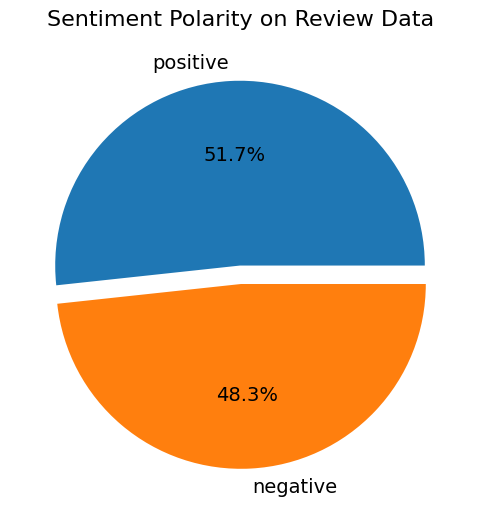

In [41]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in clean_df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyimpannya dalam list 'labels'.
labels = list(clean_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = (0.1, 0)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [42]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'positive_tweets' yang hanya berisi tweet dengan polaritas positif.
positive_tweets = clean_df[clean_df['polarity'] == 'positive']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'positive_tweets'.
positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'positive_tweets' berdasarkan 'polarity_score' secara menurun.
positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
positive_tweets = positive_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positive_tweets.index += 1

# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 3000 karakter.
pd.set_option('display.max_colwidth', 3000)

# Membuat DataFrame baru 'negative_tweets' yang hanya berisi tweet dengan polaritas negatif.
negative_tweets = clean_df[clean_df['polarity'] == 'negative']

# Memilih hanya kolom-kolom tertentu dari DataFrame 'negative_tweets'.
negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

# Mengurutkan DataFrame 'negative_tweets' berdasarkan 'polarity_score' secara menaik (ascending).
negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

# Memilih 10 baris pertama dari DataFrame yang sudah diurutkan.
negative_tweets = negative_tweets[0:10]

# Mengatur ulang indeks DataFrame agar dimulai dari 0.
negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1



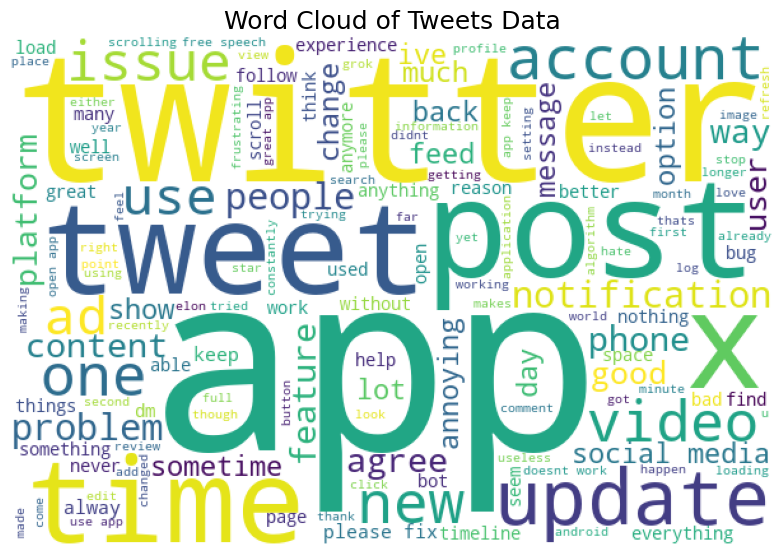

In [43]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'clean_df'.
for tweet in clean_df['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

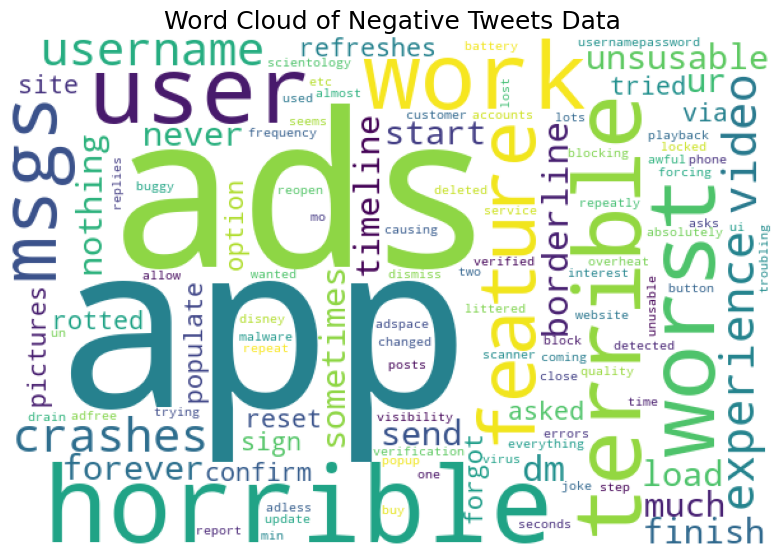

In [44]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet negatif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'negative_tweets'.
for tweet in negative_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

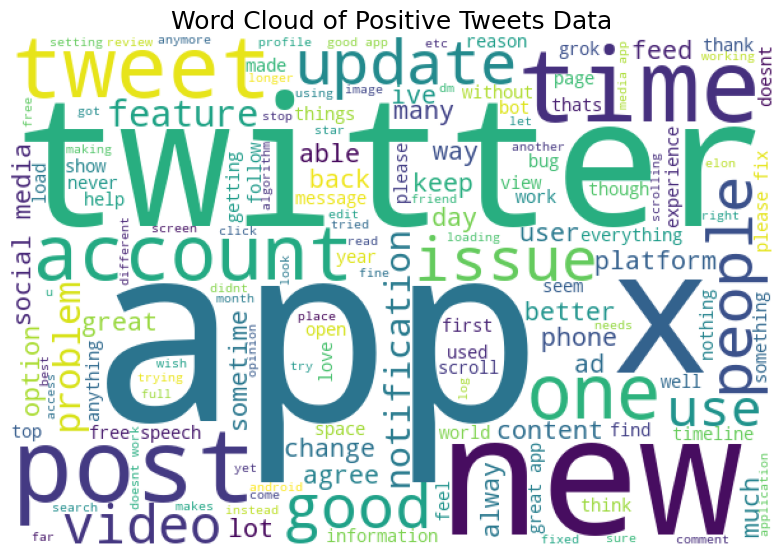

In [45]:
# Membuat string kosong 'list_words' yang akan digunakan untuk mengumpulkan semua kata dari teks yang sudah dibersihkan dalam tweet positif.
list_words = ''

# Iterasi melalui setiap tweet dalam kolom 'text_stopword' dari DataFrame 'positive_tweets'.
for tweet in positive_tweets['text_stopword']:
    # Iterasi melalui setiap kata dalam tweet.
    for word in tweet:
        # Menambahkan kata ke dalam 'list_words'.
        list_words += ' ' + (word)

# Membuat objek WordCloud dengan parameter tertentu.
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Membuat gambar dan sumbu untuk menampilkan word cloud.
fig, ax = plt.subplots(figsize=(8, 6))

# Menetapkan judul untuk word cloud.
ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)

# Menonaktifkan grid pada sumbu.
ax.grid(False)

# Menampilkan word cloud dalam gambar.
ax.imshow((wordcloud))

# Mengatur layout gambar.
fig.tight_layout(pad=0)

# Menyembunyikan sumbu.
ax.axis('off')

# Menampilkan word cloud.
plt.show()

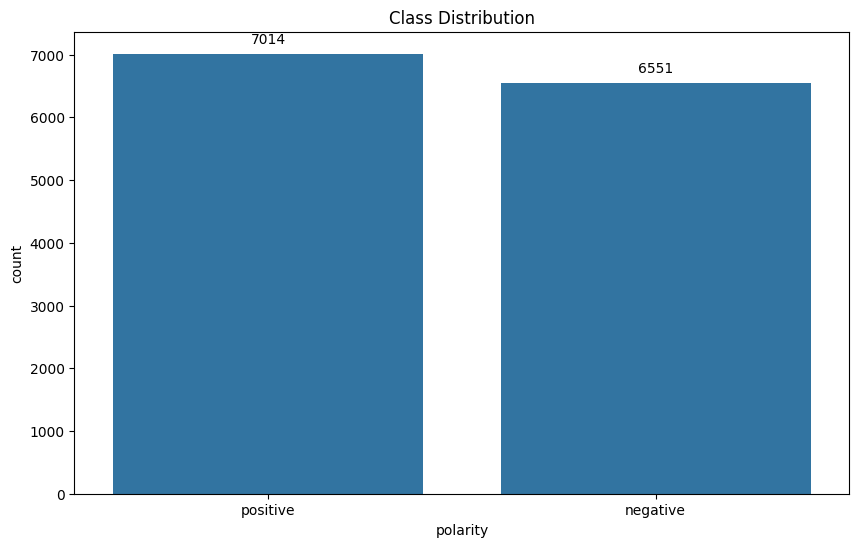

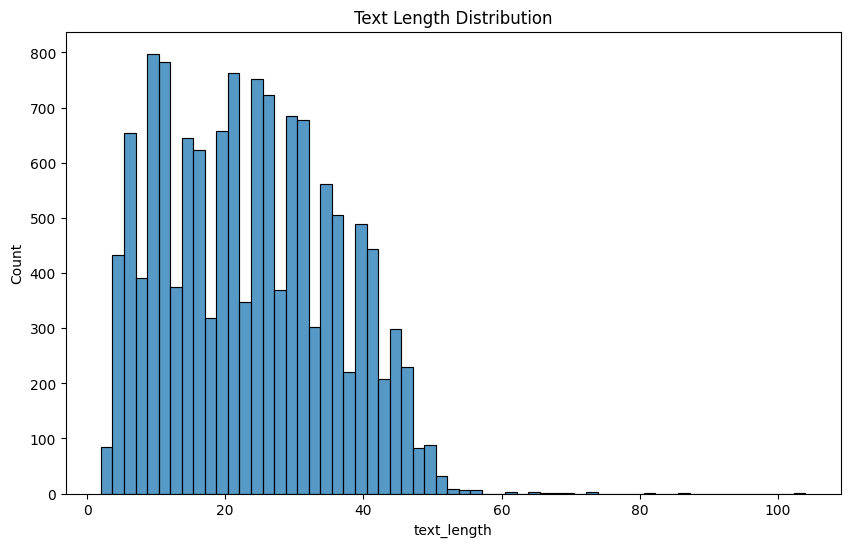

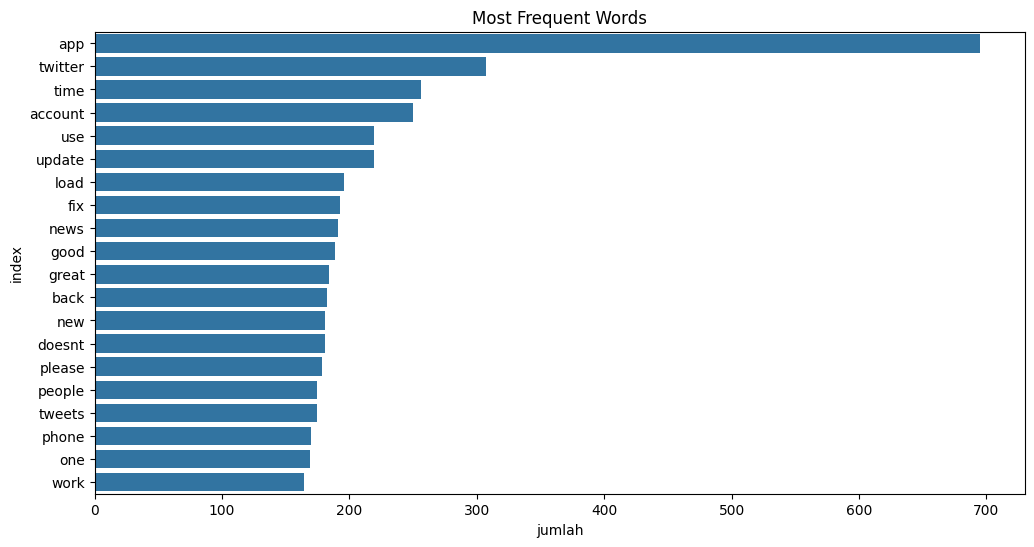

In [46]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Check class distribution
class_dist_plot = sns.countplot(x='polarity', data=clean_df)
plt.title('Class Distribution')

# Add counts above the bars on the plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Set the figure size
plt.figure(figsize=(10, 6))

# Visualize text length distribution
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(clean_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)
sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

# Data Splitting

In [47]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13565 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              13565 non-null  object 
 1   userName              13565 non-null  object 
 2   userImage             13565 non-null  object 
 3   content               13565 non-null  object 
 4   score                 13565 non-null  int64  
 5   thumbsUpCount         13565 non-null  int64  
 6   reviewCreatedVersion  13565 non-null  object 
 7   at                    13565 non-null  object 
 8   appVersion            13565 non-null  object 
 9   text_clean            13565 non-null  object 
 10  text_casefoldingText  13565 non-null  object 
 11  text_slangwords       13565 non-null  object 
 12  text_tokenizingText   13565 non-null  object 
 13  text_stopword         13565 non-null  object 
 14  text_akhir            13565 non-null  object 
 15  polarity              13

In [ ]:
X_train.shape[1]

In [48]:
clean_df['polarity'] = clean_df['polarity'].map({'positive': 1, 'negative': 0})  

# Pastikan tidak ada nilai yang hilang  
if clean_df['polarity'].isnull().any():  
    raise ValueError("Ada nilai hilang dalam kolom polarity!")  

# Pisahkan data menjadi fitur (text_akhir) dan label (polarity)  
X = clean_df['text_akhir']  
y = clean_df['polarity'].astype(int)  # Pastikan y adalah integer  

# Bagi data menjadi data latih dan data uji  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Definisikan hyperparameters untuk tokenisasi  
vocab_size = 10000  # Jumlah kata unik yang akan dipertimbangkan  
max_length = 100    # Panjang maksimum input 
embedding_dim = 128  # Ukuran embedding  

# Tokenisasi  
tokenizer = Tokenizer(num_words=vocab_size)  
tokenizer.fit_on_texts(X_train)  

X_train_seq = tokenizer.texts_to_sequences(X_train)  
X_test_seq = tokenizer.texts_to_sequences(X_test)  

# Padding sequences untuk memastikan semua input memiliki panjang yang sama  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')  
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')  

# Menampilkan bentuk data  
print("X_train_pad shape:", X_train_pad.shape)  
print("X_test_pad shape:", X_test_pad.shape)  
print("y_train shape:", y_train.shape)  
print("y_test shape:", y_test.shape)  


X_train_pad shape: (10852, 100)
X_test_pad shape: (2713, 100)
y_train shape: (10852,)
y_test shape: (2713,)


# Modeling

In [ ]:
# Membangun model LSTM  
model = Sequential()  
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))  
model.add(LSTM(64))  # Menambahkan layer LSTM  
model.add(Dense(1, activation='sigmoid'))  # Untuk binary classification (positif/negatif)  

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

# Melatih model  
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))  

# Evaluasi akurasi model LSTM pada data uji  
y_pred_test_lstm = (model.predict(X_test_pad) > 0.5).astype("int32")  
accuracy_test_lstm = accuracy_score(y_test, y_pred_test_lstm)  

# Menampilkan akurasi  
print('LSTM - accuracy_test:', accuracy_test_lstm)  

In [ ]:
# Padding sequences untuk memastikan semua input memiliki panjang yang sama  
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')  
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')  

# Membangun model RNN  
rnn_model = Sequential()  
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))  
rnn_model.add(SimpleRNN(64))  
rnn_model.add(Dense(1, activation='sigmoid'))  

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  



# Menyiapkan early stopping  
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model  
rnn_model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])  

# Evaluasi akurasi model RNN pada data uji  
y_pred_test_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")  
accuracy_test_rnn = accuracy_score(y_test, y_pred_test_rnn)  

# Menampilkan akurasi  
print('RNN - accuracy_test:', accuracy_test_rnn)  

In [51]:
# Padding sequences untuk memastikan semua input memiliki panjang yang sama  

from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM


X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')  
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')  


rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
rnn_model.add(Dropout(0.5))
rnn_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
rnn_model.add(Dense(1, activation='sigmoid'))


rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  



# Menyiapkan early stopping  
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model  
rnn_model.fit(X_train_pad, y_train, epochs=1000, batch_size=128, validation_data=(X_test_pad, y_test))  

# Evaluasi akurasi model RNN pada data uji  
y_pred_test_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")  
accuracy_test_rnn = accuracy_score(y_test, y_pred_test_rnn)  

# Menampilkan akurasi  
print('RNN - accuracy_test:', accuracy_test_rnn)  

Epoch 1/1000


d:\UB\Dicoding\GitHub\Dicoding_Akmal\.venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.5088 - loss: 0.6936 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 2/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.5237 - loss: 0.6923 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 3/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.5078 - loss: 0.6933 - val_accuracy: 0.5171 - val_loss: 0.6934
Epoch 4/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.5215 - loss: 0.6921 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 5/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.5104 - loss: 0.6931 - val_accuracy: 0.5171 - val_loss: 0.6930
Epoch 6/1000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5221 - loss: 0.6922

KeyboardInterrupt: 

In [55]:
# Padding sequences untuk memastikan semua input memiliki panjang yang sama  

from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
import tensorflow as tf


X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')  
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')  


embed_dim = 128
lstm_out = 196
max_features = 4000
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
rnn_model.add(LSTM(196))
rnn_model.add(Dense(100, activation = tf.nn.relu))
rnn_model.add(Dense(1, activation='sigmoid'))


rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

# Menyiapkan early stopping  
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Melatih model  
rnn_model.fit(X_train_pad, y_train, epochs=100, batch_size=128, validation_data=(X_test_pad, y_test))  

# Evaluasi akurasi model RNN pada data uji  
y_pred_test_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")  
accuracy_test_rnn = accuracy_score(y_test, y_pred_test_rnn)  

# Menampilkan akurasi  
print('RNN - accuracy_test:', accuracy_test_rnn)  


Epoch 1/100


85/85 ━━━━━━━━━━━━━━━━━━━━ 52s 551ms/step - accuracy: 0.5106 - loss: 0.6935 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 528ms/step - accuracy: 0.5167 - loss: 0.6932 - val_accuracy: 0.5171 - val_loss: 0.6928
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 50s 592ms/step - accuracy: 0.5117 - loss: 0.6931 - val_accuracy: 0.5171 - val_loss: 0.6927
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 46s 539ms/step - accuracy: 0.5162 - loss: 0.6934 - val_accuracy: 0.5171 - val_loss: 0.6931
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 46s 537ms/step - accuracy: 0.5158 - loss: 0.6929 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 47s 549ms/step - accuracy: 0.5192 - loss: 0.6927 - val_accuracy: 0.4829 - val_loss: 0.6933
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 527ms/step - accuracy: 0.5121 - loss: 0.6928 - val_accuracy: 0.4829 - val_loss: 0.6941
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 519ms/step - accuracy: 0.5054 - loss: 0.6932 - val_accuracy

: 

In [ ]:
# Membuat instance dari CountVectorizer  
vectorizer = CountVectorizer()  

# Menghasilkan fitur dari data pelatihan  
X_train_vectorized = vectorizer.fit_transform(X_train)  
X_test_vectorized = vectorizer.transform(X_test)  

# Model SVM  
svm_model = SVC(kernel='linear')   
svm_model.fit(X_train_vectorized, y_train)  
y_pred_svm = svm_model.predict(X_test_vectorized)  
accuracy_svm = accuracy_score(y_test, y_pred_svm)  
print('SVM - accuracy:', accuracy_svm)  

SVM - accuracy: 0.8724659049023221


In [ ]:
# Model Random Forest  
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  
rf_model.fit(X_train_vectorized, y_train)  
y_pred_rf = rf_model.predict(X_test_vectorized)  
accuracy_rf = accuracy_score(y_test, y_pred_rf)  
print('Random Forest - accuracy:', accuracy_rf)  


Random Forest - accuracy: 0.8138591964614817


In [ ]:
# Model Logistic Regression  
lr_model = LogisticRegression(max_iter=200)  
lr_model.fit(X_train_vectorized, y_train)  

# Prediksi untuk data pelatihan dan pengujian  
y_pred_train = lr_model.predict(X_train_vectorized)  
y_pred_test = lr_model.predict(X_test_vectorized)  

# Menghitung akurasi  
accuracy_train = accuracy_score(y_train, y_pred_train)  
accuracy_test = accuracy_score(y_test, y_pred_test)  

# Menampilkan akurasi dari data pelatihan dan pengujian  
print('Logistic Regression - accuracy on training data:', accuracy_train)  
print('Logistic Regression - accuracy on test data:', accuracy_test)  

Logistic Regression - accuracy on training data: 0.9871913011426465
Logistic Regression - accuracy on test data: 0.879100626612606


In [ ]:
kalimat_baru = "I had a very good experience in this app"
# Melakukan preprocessing pada kalimat baru  
kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)   
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

# Menggunakan objek vectorizer yang sudah di-fit dari pelatihan sebelumnya  
X_kalimat_baru = vectorizer.transform([kalimat_baru_final]) 
# Memperoleh prediksi sentimen kalimat baru  
prediksi_sentimen = lr_model.predict(X_kalimat_baru)  

# Menampilkan hasil prediksi  
if prediksi_sentimen[0] == 1:  # Untuk model binary, 1 berarti positif  
    print("Sentimen kalimat baru adalah POSITIF.")  
else:  # 0 berarti negatif  
    print("Sentimen kalimat baru adalah NEGATIF.")  

Sentimen kalimat baru adalah POSITIF.


In [ ]:
from sklearn.naive_bayes import MultinomialNB  

# Model Naive Bayes  
nb_model = MultinomialNB()  
nb_model.fit(X_train_vectorized, y_train)  

# Prediksi untuk data pengujian  
y_pred_test = nb_model.predict(X_test_vectorized)  

# Menghitung akurasi  
accuracy_test = accuracy_score(y_test, y_pred_test)  
print('Naive Bayes - accuracy on test data:', accuracy_test)  

Naive Bayes - accuracy on test data: 0.7622558053814965


In [ ]:
# OPTIONAL: Input kalimat baru dari pengguna untuk prediksi  
kalimat_baru = "I had a very good experience in this app"  # Kalimat baru yang ingin diprediksi sentimennya

# Melakukan preprocessing pada kalimat baru  
kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefoldingText(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)   
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

# Menggunakan objek vectorizer yang sudah di-fit dari pelatihan sebelumnya  
X_kalimat_baru = vectorizer.transform([kalimat_baru_final]) 

# Memperoleh prediksi sentimen kalimat baru  
prediksi_sentimen = nb_model.predict(X_kalimat_baru)  

# Menampilkan hasil prediksi  
if prediksi_sentimen[0] == 1:  # Untuk model binary, 1 berarti positif  
    print("Sentimen kalimat baru adalah POSITIF.")  
else:  # 0 berarti negatif  
    print("Sentimen kalimat baru adalah NEGATIF.")  

Sentimen kalimat baru adalah POSITIF.
